Currently, a grocery company manually groups the items into a few categories based on experience. 
However, armed with the purchase history from users, they can cluster items based on user co-purchase history, meaing creating clusters of products that have the highest probability of being bought together. 

The goal of this is to replace the manual creation of categories with a ML cluster algorithm. Each item will be in just one cluster.



In [1]:
import re
from collections import Counter
import itertools

import numpy as np
import pandas as pd

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline



RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [2]:
items = pd.read_csv("item_to_id.csv", index_col='Item_id')
items.sort_index(inplace=True)
items.head()

,Item_name
Item_id,
1,sugar
2,lettuce
3,pet items
4,baby items
5,waffles


In [3]:
purchase_history = pd.read_csv("purchase_history.csv")
purchase_history.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [4]:
def item_counts_by_user(same_user_df):
    # 'sum' here is adding two lists into one big list
    all_item_ids = same_user_df['id'].str.split(',').sum()
    # transform from string to int, make it easier to be sorted later
    return pd.Series(Counter(int(id) for id in all_item_ids))


In [5]:
user_item_counts = purchase_history.groupby("user_id").apply(item_counts_by_user).unstack(fill_value=0)

### Clustering based on item - item similarity

In [6]:
A = normalize(user_item_counts.values, axis=0)
item_item_similarity = A.T.dot(A)
item_item_similarity = pd.DataFrame(item_item_similarity,
                                    index=user_item_counts.columns,
                                    columns=user_item_counts.columns)

/home/amywu/anaconda3/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [7]:
item_item_similarity.head() # get a feeling about the data

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
1,1.000000,0.506895,0.420145,0.296986,0.271132,0.388250,0.271743,0.335303,0.403690,0.390641,...,0.388034,0.390286,0.358599,0.393056,0.395696,0.396766,0.390253,0.394998,0.392164,0.328221
2,0.506895,1.000000,0.466874,0.322744,0.285125,0.468199,0.312200,0.390521,0.464872,0.527894,...,0.462968,0.462548,0.409401,0.529100,0.464579,0.527325,0.521058,0.462407,0.460257,0.380077
3,0.420145,0.466874,1.000000,0.277325,0.224537,0.358326,0.238133,0.301868,0.362091,0.352597,...,0.351093,0.368199,0.309078,0.357794,0.351209,0.362522,0.361922,0.354933,0.351832,0.297972
4,0.296986,0.322744,0.277325,1.000000,0.162860,0.247414,0.166012,0.216166,0.252662,0.258313,...,0.245623,0.261272,0.210767,0.244946,0.253282,0.253119,0.250190,0.253835,0.260541,0.218717
5,0.271132,0.285125,0.224537,0.162860,1.000000,0.233618,0.164699,0.203245,0.239445,0.234254,...,0.235543,0.238557,0.211006,0.238466,0.235064,0.241835,0.238087,0.238247,0.232387,0.188269


In [8]:
pca = PCA()
# rotate by PCA, making it easier to be visualized later
items_rotated = pca.fit_transform(item_item_similarity)
items_rotated = pd.DataFrame(items_rotated,
                             index = user_item_counts.columns,
                             columns = ["pc{}".format(index+1) for index in xrange(items.shape[0])])


In [9]:
def show_clusters(items_rotated,labels):
    """
    plot and print clustering result
    """
    fig = plt.figure(figsize=(15, 15))
    colors =  itertools.cycle (["b","g","r","c","m","y","k"])

    grps = items_rotated.groupby(labels)
    for label,grp in grps:
        plt.scatter(grp.pc1,grp.pc2,c=next(colors),label = label)

        print "*********** Label [{}] ***********".format(label)
        names = items.loc[ grp.index,"Item_name"]
        for index, name in enumerate(names):
            print "\t<{}> {}".format(index+1,name)

    # annotate
    for itemid in items_rotated.index:
        x = items_rotated.loc[itemid, "pc1"]
        y = items_rotated.loc[itemid, "pc2"]
        name = items.loc[itemid, "Item_name"]
        name = re.sub('\W', ' ', name)
        plt.text(x,y,name)

    # plt.legend(loc="best")

In [10]:
def cluster(n_clusters,n_components=48):
    """
    n_components=K, means use first K principle components in the clustering
    n_clusters: the number of clusters we want to cluster
    """
    print "first {} PC explain {:.1f}% variances".format(n_components,
                                                         100 * sum(pca.explained_variance_ratio_[:n_components]))

    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(items_rotated.values[:, :n_components])

    # display results
    show_clusters(items_rotated, kmeans.labels_)

In [11]:
# choose best K (i.e., number of clusters)
inertias = []
silhouettes = []

ks = range(2,30)
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(items_rotated)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(items_rotated, kmeans.predict(items_rotated)))


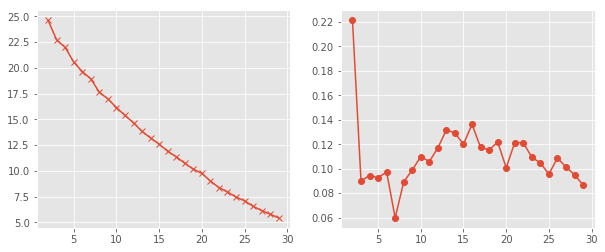

In [12]:
fig = plt.figure(figsize = (10,4))
fig.add_subplot(1,2,1)
plt.plot(ks, inertias, marker = 'x')# want to use elbow method to find best k

fig.add_subplot(1,2,2)
plt.plot(ks, silhouettes, marker = 'o')# the higher the better

first 48 PC explain 100.0% variances
*********** Label [0] ***********
	<1> lettuce
	<2> carrots
	<3> cucumbers
	<4> broccoli
	<5> cauliflower
*********** Label [1] ***********
	<1> butter
	<2> eggs
	<3> milk
	<4> cheeses
	<5> yogurt
*********** Label [2] ***********
	<1> cereals
*********** Label [3] ***********
	<1> sandwich bags
	<2> aluminum foil
	<3> paper towels
	<4> toilet paper
*********** Label [4] ***********
	<1> shampoo
	<2> shaving cream
	<3> hand soap
	<4> soap
*********** Label [5] ***********
	<1> grapefruit
	<2> cherries
	<3> apples
	<4> berries
	<5> bananas
*********** Label [6] ***********
	<1> spaghetti sauce
	<2> canned vegetables
	<3> ketchup
*********** Label [7] ***********
	<1> sugar
	<2> pet items
	<3> poultry
	<4> beef
	<5> pork
*********** Label [8] ***********
	<1> flour
*********** Label [9] ***********
	<1> baby items
*********** Label [10] ***********
	<1> bagels
	<2> tortillas
	<3> dinner rolls
	<4> sandwich loaves
*********** Label [11] ***********
	<1

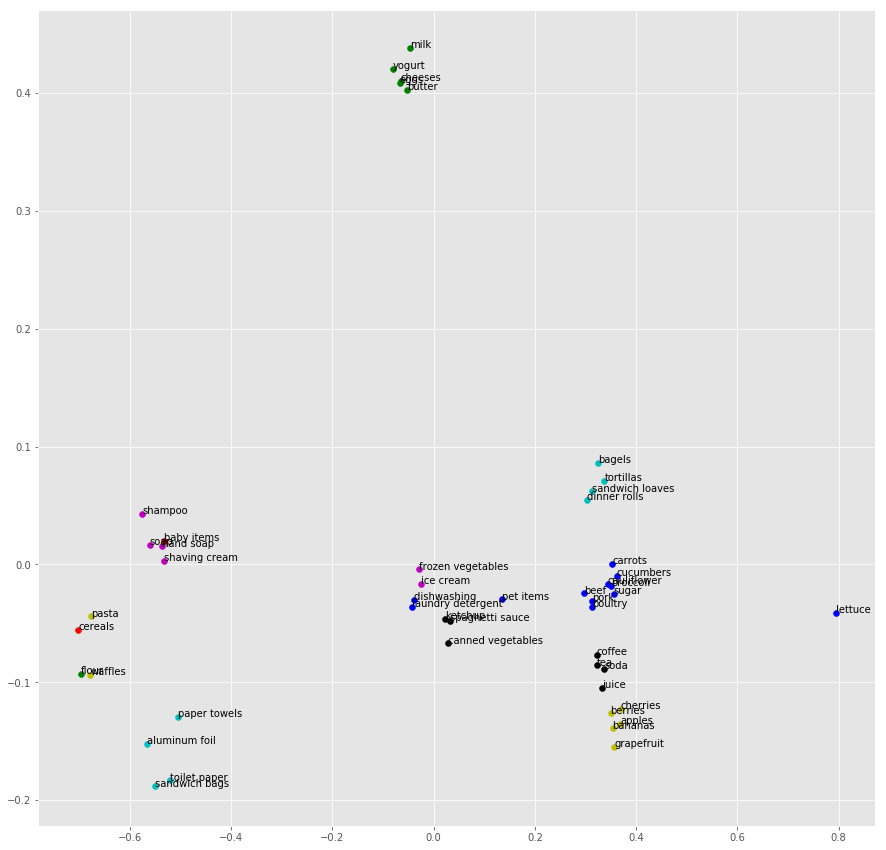

In [13]:
# use all the components
cluster(n_clusters = 15)